In [1]:
import pandas as pd
import numpy as np
from config_loader import load
import argparse
import sys
import seaborn as sns
from MyDataUnderstanding import featureAnalysis
from MyPreprocessing import MyPreprocessing
import numpy as np
from time import time
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [3]:
def getData(path, filenames_type):
    '''
    features_lst = [
        "Pclass", "Survived", "Name", "Sex", "Age",
        "Sibsp", "Parch", "Ticket", "Fare", "Cabin","Embarked",
        "Boat","Body","Home.dest"]
    '''
    if filenames_type == 'train':
        filename = 'train'
    elif filenames_type == 'test':
        filename = 'test'
    else:
        filename = 'titanicAll'
        
    df_features = pd.read_csv(path + filename + '.csv',
                           sep=',')

    if filename not in ['train', 'test']:
        # drop unnecessary columns that don't exist in the official data
        df_features.drop(['Boat', 'Body', 'Home.dest'],
                           axis=1,
                           inplace=True)
    #labels = df_features['Survived']
    #df_features = df_features.drop(['Survived'], axis=1)
    return df_features

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "-c", "--config", default="titanic.cfg",
    help="specify the location of the clustering config file"
)
args, _ = parser.parse_known_args()

config_file = args.config
config = load(config_file)

##
verbose = config.get('titanic', 'verbose')
path = config.get('titanic', 'path') + '/'
file_type = config.get('titanic', 'file_type')

filename_type = 'train'
if file_type == 'all':
    filename_type = 'other'

train = getData(path, filename_type)

In [5]:
featureAnalysis(train)

Data summary
       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

Categorical data summary
                             Name   Sex  Ticket Cabin Embarked
count                         891   891     891   204      889
unique          

* Names are unique across the dataset
* Sex variable as two possible values with 65% male (top=female, freq=577/count(=891)).
* Cabin values have several dupicates across samples or several passengers shared a cabin but there are also many missing values (77%)
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (23%) of duplicate values

In [6]:
test = getData(path, 'test')
featureAnalysis(test)

Data summary
       PassengerId      Pclass         Age       SibSp       Parch        Fare    Survived
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000  418.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188    0.380383
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576    0.486063
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800    0.000000
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200    0.000000
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000    1.000000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200    1.000000

Categorical data summary
                              Name   Sex    Ticket            Cabin Embarked
count                          418   418       418               

In [7]:
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

# Outlier Detection for numerical values
(missing values handle)

In [9]:
train = train.fillna(np.NaN)

Turkey method

Detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile
of the distribution values (IQR). An outlier is a row that have a feature value outside the 
(IQR +- an outlier step).

To detect outliers from the numerical values features (Age, SibSp, Sarch, Fare , Pclass). 
Rows that have at least two outlied numerical values are considered outliers.

In [10]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare","Pclass"])

c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [11]:
train.iloc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10 outliers

The 27, 88 and 341 passenger have an high Ticket Fare

The 7 others have very high values of SibSP.

Most of them have NaN value in Age column

# Missing Values

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

*Cabin*  
*Age*  
Embarked  
Fare  

# Feature Analysis

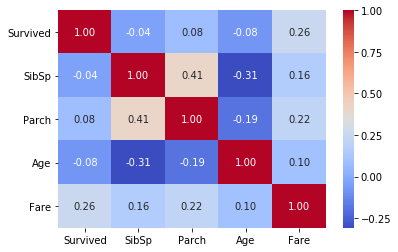

In [14]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Biggest correlation of Survived with Fare  
Also, Parch with Sibsp (maybe we will merge them)

In [15]:
train['Died'] = 1 - train.Survived

### Sex

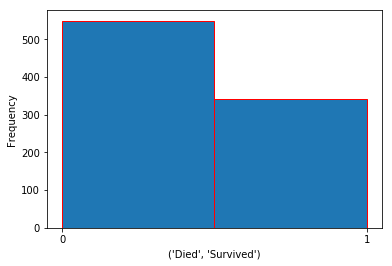

0    549
1    342
Name: Survived, dtype: int64

In [16]:
train.Survived.plot(kind='hist', bins = 2, edgecolor = 'red')
plt.xticks((1, 0))
plt.xlabel(('Died','Survived'))
plt.show()
train.Survived.value_counts()

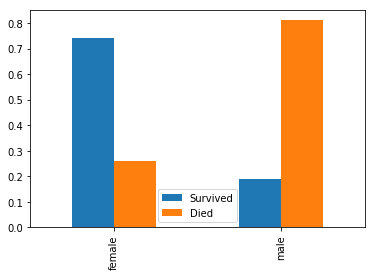

In [17]:
sex_cor_survived = train[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)
sex_cor_died = train[['Sex', 'Died']].groupby(['Sex']).mean().sort_values(by='Died', ascending=False)
 
sex_cor = pd.concat([sex_cor_survived, sex_cor_died], axis=1, sort=False)
sex_cor.plot.bar()

### Age

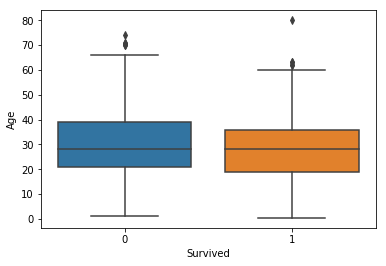

In [18]:
sns.boxplot(x='Survived',y='Age',data=train)

c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


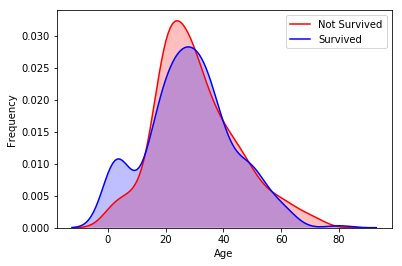

In [19]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Babies and children survive

c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


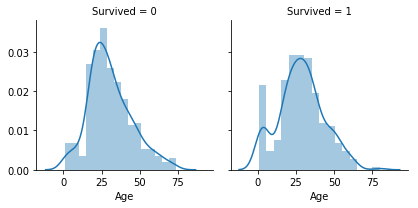

In [20]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Even if "Age" is not correlated with "Survived", there are age categories of passengers that have more or less chance to survive.

### Pclass

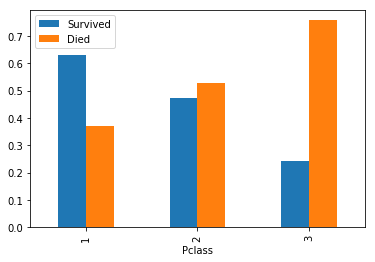

In [21]:
class_cor_survived = train[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)
class_cor_died = train[['Pclass', 'Died']].groupby(['Pclass']).mean().sort_values(by='Died', ascending=False)
 
class_cor = pd.concat([class_cor_survived, class_cor_died], axis=1, sort=False)
class_cor.plot.bar()

Pclass 1 much more chance to survive

### Pclass & Age

<Figure size 1080x720 with 0 Axes>

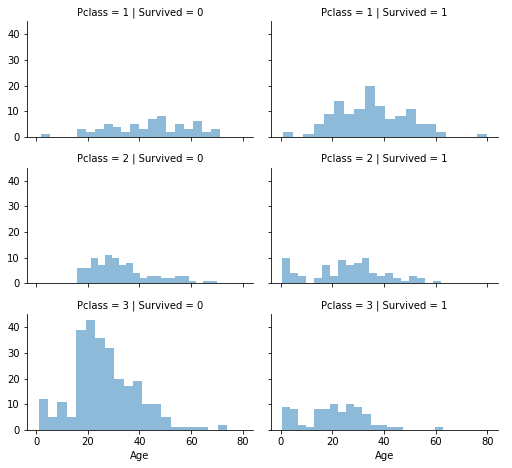

<Figure size 1080x720 with 0 Axes>

In [22]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();plt.figure(figsize=(15,10))

There are many who were not young who survived from Class 1  
There are many from Class 3 who didn't survive from 20-30 years old

### Pclass & Sex

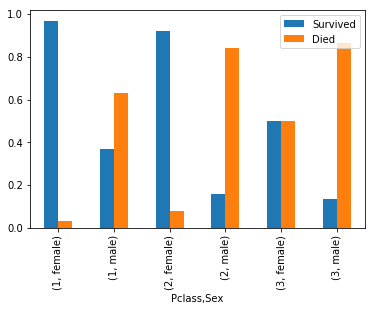

In [23]:
class_cor_survived = train[['Sex', 'Pclass', 'Survived']].groupby(['Pclass','Sex']).mean().sort_values(by='Survived', ascending=False)
class_cor_died = train[['Sex','Pclass', 'Died']].groupby(['Pclass','Sex']).mean().sort_values(by='Died', ascending=False)
 
class_cor = pd.concat([class_cor_survived, class_cor_died], axis=1, sort=False)
class_cor.plot.bar()

Upper and middle class women mostly survived, not so much for the lower class. None of the men did particularly well, especially those in the lower class.

### Parch & SibSp

In [24]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

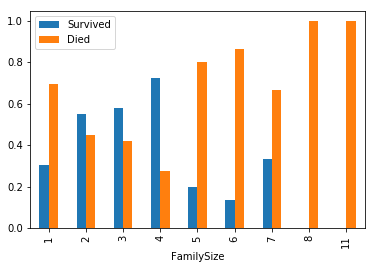

In [25]:
fam_cor_survived = train[['FamilySize', 'Survived']].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=False)
fam_cor_died = train[['FamilySize', 'Died']].groupby(['FamilySize']).mean().sort_values(by='Died', ascending=False)
 
fam_cor = pd.concat([fam_cor_survived, fam_cor_died], axis=1, sort=False)
fam_cor.plot.bar()

Bigger families have less chance to survive

### Fare

Text(0,0.5,'Count')

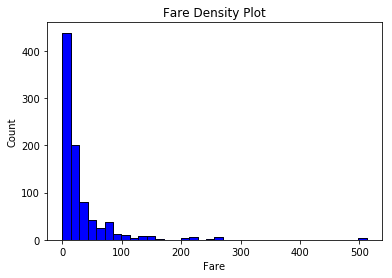

In [26]:
# matplotlib histogram
fare = train['Fare'][~np.isnan(train['Fare'])]
plt.hist(fare, color = 'blue', edgecolor = 'black', bins = 36)

# seaborn histogram
sns.distplot(fare, hist=True, kde=False, 
             color = 'blue', bins = 36,
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Fare Density Plot')
plt.xlabel('Fare')
plt.ylabel('Count')

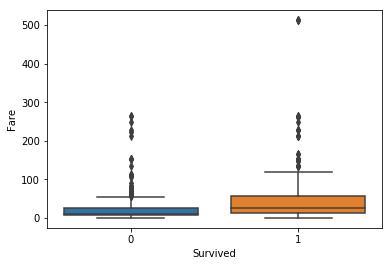

In [27]:
sns.boxplot(x='Survived',y='Fare',data=train)

In [28]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

### Cabin

In [29]:
cabin_cor_survived = train[['Cabin', 'Survived']].groupby(['Cabin']).mean().sort_values(by='Survived', ascending=False)
cabin_cor_survived

,Survived
Cabin,
C62 C64,1.000000
D21,1.000000
D17,1.000000
D19,1.000000
C148,1.000000
D20,1.000000
C126,1.000000
C125,1.000000
E40,1.000000


In [30]:
train.Cabin.isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

### Ticket 

In [31]:
train[train.Ticket == '1601'].Name, train[train.Ticket == '1601'].Survived 

(74       Bing, Mr. Lee
 169      Ling, Mr. Lee
 509     Lang, Mr. Fang
 643    Foo, Mr. Choong
 692       Lam, Mr. Ali
 826       Lam, Mr. Len
 838    Chip, Mr. Chang
 Name: Name, dtype: object, 74     1
 169    0
 509    1
 643    1
 692    1
 826    0
 838    1
 Name: Survived, dtype: int64)

In [32]:
train[train.Ticket == '347082'].Name, train[train.Ticket == '347082'].Survived

(13                           Andersson, Mr. Anders Johan
 119                    Andersson, Miss. Ellis Anna Maria
 541                 Andersson, Miss. Ingeborg Constanzia
 542                    Andersson, Miss. Sigrid Elisabeth
 610    Andersson, Mrs. Anders Johan (Alfrida Konstant...
 813                   Andersson, Miss. Ebba Iris Alfrida
 850              Andersson, Master. Sigvard Harald Elias
 Name: Name, dtype: object, 13     0
 119    0
 541    0
 542    0
 610    0
 813    0
 850    0
 Name: Survived, dtype: int64)

In [33]:
train[train.Ticket == '347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died,FamilySize
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,1,7
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,1,7
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,1,7
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,1,7
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,1,7
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,1,7
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,1,7


we can see that sometimes, but not always, a family shares the same ticket number

### Embarked

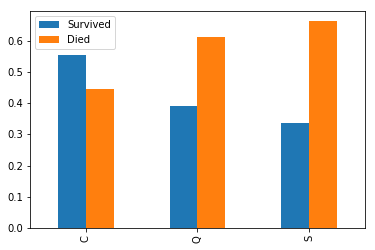

In [34]:
deck_cor_survived = train[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False)
deck_cor_died = train[['Embarked', 'Died']].groupby(['Embarked']).mean().sort_values(by='Died', ascending=False)

deck_cor = pd.concat([deck_cor_survived, deck_cor_died], axis=1, sort=False)
deck_cor.plot.bar()

In [35]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died,FamilySize
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,1


No deck info but they are in Class 1

## Pre-Feature Engineering & Missing Values

In [36]:
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [37]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `ki

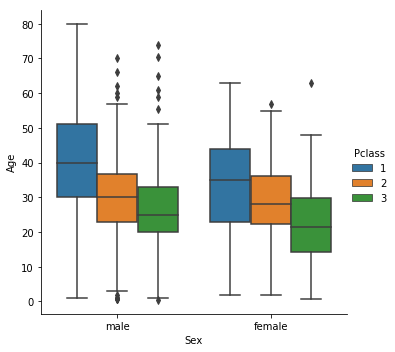

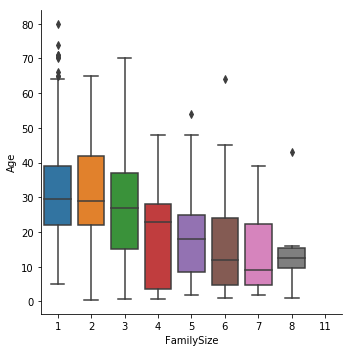

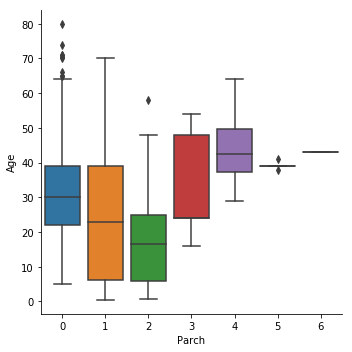

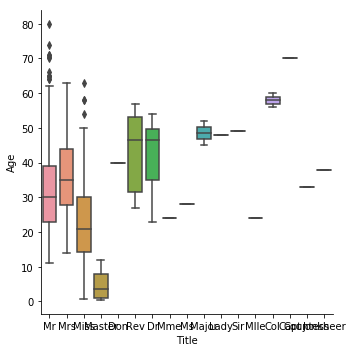

In [38]:
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=train,kind="box")
g = sns.factorplot(y="Age",x="FamilySize", data=train,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=train,kind="box")
g = sns.factorplot(y="Age",x="Title", data=train,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.  
As we noticed before, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.  
Also, the older the passenger is the higher value in Parch  
For sure, there is a relation of the age and the title since young ages are called Masters, around 30 Mr or Miss or Mrs 

In [39]:
# Fill NaN of Age column taking into account the Title and the No of Parch
train['Age'] = train.Age.fillna(train.groupby(['Title', 'Parch'])['Age'].transform('median'))
# there are still 2 missing values because there is a case where the
# combination of the condition includes just NaN values
train['Age'] = train.Age.fillna(train.groupby(['Title'])['Age'].transform('median'))
# for remaining NaNs
train['Age'] = train.Age.fillna(train.Age.mean())

In [40]:
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

In [41]:
# for test
train.Fare.fillna(train.Fare.median(), inplace=True)

Cabin column has far too many NaNs and it doesn't worth to find any correlations with the other variables.

# Feature Engineering

In [42]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.263378,0.523008,0.381594,32.204208,0.616162,1.904602
std,257.353842,0.486592,0.836071,13.340614,1.102743,0.806057,49.693429,0.486592,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,11.000000


### Title

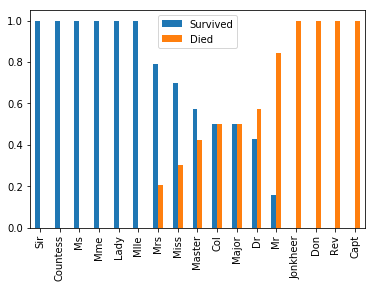

In [43]:
title_cor_survived = train[['Title', 'Survived']].groupby(['Title']).mean().sort_values(by='Survived', ascending=False)
title_cor_died = train[['Title', 'Died']].groupby(['Title']).mean().sort_values(by='Died', ascending=False)

title_cor = pd.concat([title_cor_survived, title_cor_died], axis=1, sort=False)
title_cor.plot.bar()

In [44]:
def replace_titles(x):
    title = x.Title
    # Female titles which are associated with survival=1
    if title in ['Countess', 'Mme' , 'Dona', 'Mlle', 'Lady']:
        return 'Ms'
    # Female titles that are associated with survival~0.7
    elif title in ['Mrs', 'Miss']:
        return 'Mrs'
    elif title == 'Dr' and x['Sex'] == 'female':
        # The female doctor survives so goes with survival=1
        return 'Ms'
    # The male doctor survives so goes with survival=0.5
    elif title in ['Sir', 'Dr', 'Master', 'Col', 'Major']:
        return 'Mr50'
    # The male doctor survives so goes with survival=0
    elif title in ['Jonkheer', 'Don', 'Rev', 'Capt']:
        return 'Mr0'
    else:
        # Mr is 16% and Ms is 50% survival
        return title
train['Title'] = train.apply(replace_titles, axis=1)

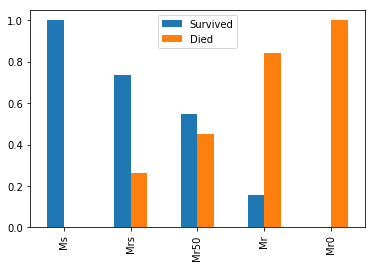

In [45]:
title_cor_survived = train[['Title', 'Survived']].groupby(['Title']).mean().sort_values(by='Survived', ascending=False)
title_cor_died = train[['Title', 'Died']].groupby(['Title']).mean().sort_values(by='Died', ascending=False)

title_cor = pd.concat([title_cor_survived, title_cor_died], axis=1, sort=False)
title_cor.plot.bar()

Like that there are specific classes that survive always

In [46]:
train = pd.get_dummies(train, columns=['Title'], drop_first=True)

### Sex

In [47]:
#need to give males and females numeric values 
train.loc[train["Sex"] == "male", "Sex"] = 0
train.loc[train["Sex"] == "female", "Sex"] = 1

### Age

In [48]:
#Various ages
train['Age_bin'] = pd.cut(train['Age'], bins=[-1,2,12,17,120], 
                             labels=['Infant','Kid','Teenager','Adult'])

#train['Infant'] = train['Age'] <= 2
#train['Kid'] = (train['Age'] > 3) & (train['Age'] <= 12)
#train['Teenager'] = (train['Age'] > 13) & (train['Age'] <= 17)
#train['Adult'] = train['Age'] >= 18

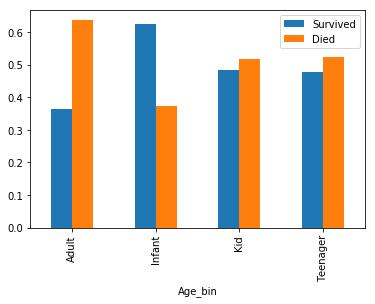

In [49]:
age_cor_survived = train[['Age_bin', 'Survived']].groupby(['Age_bin']).mean().sort_values(by='Survived', ascending=False)
age_cor_died = train[['Age_bin', 'Died']].groupby(['Age_bin']).mean().sort_values(by='Died', ascending=False)

age_cor = pd.concat([age_cor_survived, age_cor_died], axis=1, sort=False)
age_cor.plot.bar()

In [50]:
train = pd.get_dummies(train, columns=['Age_bin'], drop_first=True)

### Parch-SibSp => FamilySize

In [51]:
#Family size is the sum of siblings, spouses, parents, and children.
train['Family_bin'] = pd.cut(train['FamilySize'], bins=[0,1,4,7,12], 
                             labels=['Single','SmallFamily','BigFamily','Team'])

#train['Single'] = (train['FamilySize'] == 1).map(lambda s: 1 if s else 0) 
#train['SmallFamily'] = ((train['FamilySize'] >= 2) & ((train['FamilySize'] <= 4))).map(lambda s: 1 if s else 0)
#train['BigFamily'] = ((train['FamilySize'] >= 5) & (train['FamilySize'] <= 7)).map(lambda s: 1 if s else 0)
#train['Team'] = (train['FamilySize'] >= 8).map(lambda s: 1 if s else 0)

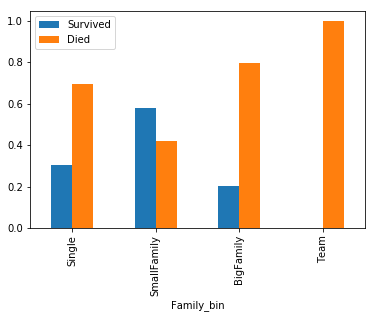

In [52]:
fam_cor_s = train[['Family_bin', 'Survived']].groupby(['Family_bin']).mean()
fam_cor_d = train[['Family_bin', 'Died']].groupby(['Family_bin']).mean()

fam_cor = pd.concat([fam_cor_s, fam_cor_d], axis=1, sort=False)
fam_cor.plot.bar()

Big big families ("Teams") don't survive at all

In [53]:
train = pd.get_dummies(train, columns=['Family_bin'], drop_first=True)

### Fare

In [54]:
train['Fare_bin'] = pd.cut(train['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low','Median',
                                                                              'Average','High'])

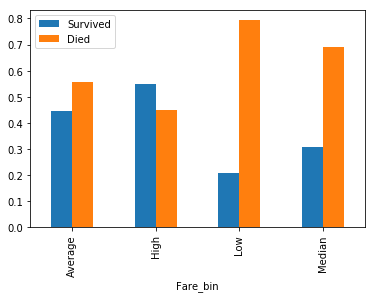

In [55]:
fare_cor_survived = train[['Fare_bin', 'Survived']].groupby(['Fare_bin']).mean().sort_values(by='Survived', ascending=False)
fare_cor_died = train[['Fare_bin', 'Died']].groupby(['Fare_bin']).mean().sort_values(by='Died', ascending=False)
 
fare_cor = pd.concat([fare_cor_survived, fare_cor_died], axis=1, sort=False)
fare_cor.plot.bar()

In [56]:
train = pd.get_dummies(train, columns=['Fare_bin'], drop_first=True)

### Embarked

In [57]:
train = pd.get_dummies(train, columns = ["Embarked"], prefix="Em")

### Cabin

In [58]:
# Replace the Cabin number by the type of cabin 'X' if not
train['Cabin'] = train['Cabin'].str.extract("([a-zA-Z]+)", expand=True)
train['Cabin'] = train['Cabin'].fillna("X")

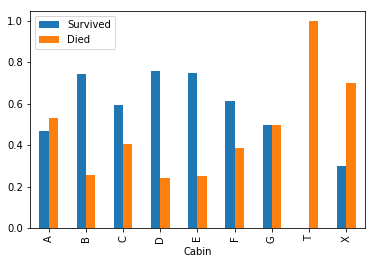

In [59]:
cab_cor_s = train[['Cabin', 'Survived']].groupby(['Cabin']).mean()
cab_cor_d = train[['Cabin', 'Died']].groupby(['Cabin']).mean()

cab_cor = pd.concat([cab_cor_s, cab_cor_d], axis=1, sort=False)
cab_cor.plot.bar()

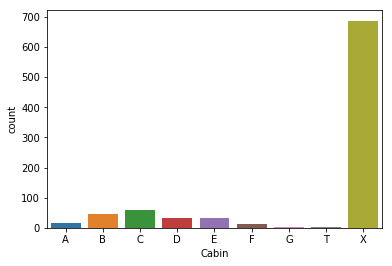

In [60]:
g = sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

In general, passengers with a cabin have generally more chance to survive than passengers without (X).

In [61]:
train = pd.get_dummies(train, columns = ["Cabin"],prefix="Cabin")

### Ticket

In [62]:
#Find the length of the ticket, perhaps longer tickets are for include more amenities, 
#therefore associated with wealth.
train['TicketLength'] = train['Ticket'].map(lambda x: len(x))

c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


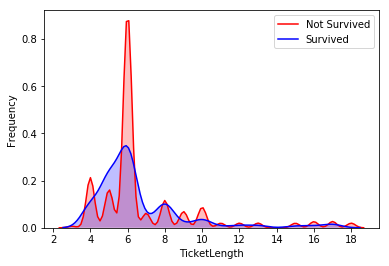

In [63]:
g = sns.kdeplot(train["TicketLength"][(train["Survived"] == 0) & (train["TicketLength"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["TicketLength"][(train["Survived"] == 1) & (train["TicketLength"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("TicketLength")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Text(0,0.5,'Count')

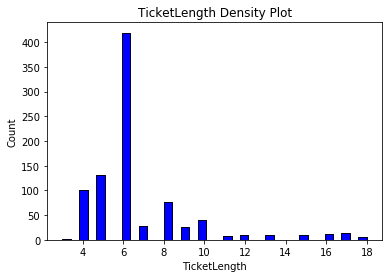

In [64]:
# matplotlib histogram
fare = train['TicketLength'][~np.isnan(train['TicketLength'])]
plt.hist(fare, color = 'blue', edgecolor = 'black', bins = 36)

# seaborn histogram
sns.distplot(fare, hist=True, kde=False, 
             color = 'blue', bins = 36,
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('TicketLength Density Plot')
plt.xlabel('TicketLength')
plt.ylabel('Count')

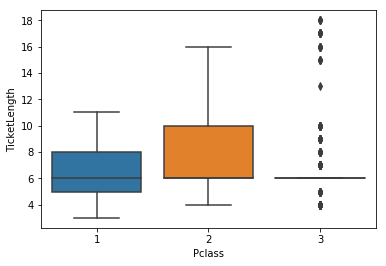

In [65]:
sns.boxplot(x='Pclass',y='TicketLength',data=train)

In [66]:
train.TicketLength.describe()

count    891.000000
mean       6.750842
std        2.745515
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       18.000000
Name: TicketLength, dtype: float64

In [88]:
train['TicketL_bin'] = pd.cut(train['TicketLength'], bins=[0,5,8,10,20], labels=['Small','Average',
                                                                              'Big','Huge'])

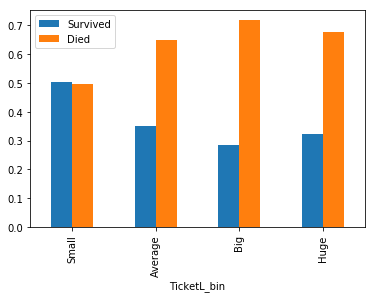

In [89]:
cor_s = train[['TicketL_bin', 'Survived']].groupby(['TicketL_bin']).mean()
cor_d = train[['TicketL_bin', 'Died']].groupby(['TicketL_bin']).mean()

cor = pd.concat([cor_s, cor_d], axis=1, sort=False)
cor.plot.bar()

TicketLength doesn't seem as a very good new feature and it will may will be dropped

In [69]:
def get_ticket_id(row):
    ticket = row.Ticket
    if ticket.isdigit():
        return 'N'
    else:
        ticket_id = ticket.replace('.','').replace('/','').split()[0]
        return ticket_id


#train['TicketID'] = train.apply(get_ticket_id, axis=1)

In [70]:
train['TicketID'] = train.apply(get_ticket_id, axis=1)

In [71]:
test['TicketID'] = train.apply(get_ticket_id, axis=1)

In [ ]:
train['TicketID'] = train.apply(get_ticket_id, axis=1)

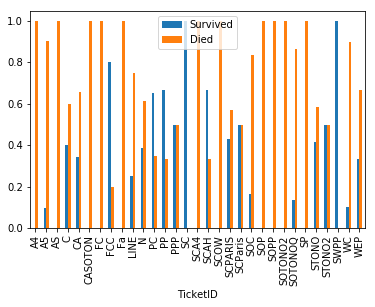

In [72]:
cor_s = train[['TicketID', 'Survived']].groupby(['TicketID']).mean()
cor_d = train[['TicketID', 'Died']].groupby(['TicketID']).mean()

cor = pd.concat([cor_s, cor_d], axis=1, sort=False)
cor.plot.bar()

In [73]:
# TEST TICKET:
# A5, AQ3, AQ4, FC, LP, SC,SCA3, SCA4, SCAH, SOC, STONO, STONO2, STONOQ -> x
# A,FC, PP, SCParis, WEP -> ok

Ticket ID may will be dropped as well

### Extra features

In [74]:
#If someone has a sibling or spouse onboard, SibSp needs to be 1 or greater.
#train['Has_SibSp'] = train['SibSp'].map(lambda x: 1 if x >= 1 else 0)

In [75]:
#To be a parent, you need a spouse, have at least 1 child, and be older than 18.
#SibSp is >= 0 because you could be an adult with a sibling on board.
parent = (train['Parch'] > 0) & (train['Age'] >= 18)

#To be a mother, you need to be a parent and female. Fathers = Parent & Male
train['Mother'] = ((parent == 1) & (train['Sex'] == 1)).map(lambda s: 1 if s else 0) 
train['Father'] = ((parent == 1) & (train['Sex'] == 0)).map(lambda s: 1 if s else 0) 

#Child has at least 1 parent and is 17 or younger
child = (train['Parch'] >= 1) & (train['Age'] <= 17)

#To be a daughter, you need to be a girl, and a child.
#To be a son, likewise, but a boy.
train['Daughter'] = ((train['Sex'] == 1) & (child == 1)).map(lambda s: 1 if s else 0) 
train['Son'] = ((train['Sex'] == 0) & (child == 1)).map(lambda s: 1 if s else 0) 

#Orphan if you have no parents and are 17 or younger
train['Orphan'] = ((train['Age'] <= 17) & (train['Parch'] == 0)).map(lambda s: 1 if s else 0) 

#To be single, must be 18 or older, no parents/children, no siblings/spouses.
#train['Single_Man'] = (train['Sex'] == 0) & (train['Age'] >= 18) & (train['SibSp'] == 0) & (train['Parch'] == 0)
#train['Single_Woman'] = (train['Sex'] == 1) & (train['Age'] >= 18) & (train['SibSp'] == 0) & (train['Parch'] == 0)

#Married without kids or parents, need to be at least 18, and have at least 1 sibling or spouse.
#train['Married_no_Kids_no_Parents'] = (train['SibSp'] >= 1) & (train['Parch'] == 0) & (train['Age'] >= 18)

In [76]:
#Combined class and gender to better organize people.
train['RichWoman'] = ((train['Pclass'] == 1) & (train['Sex'] == 1) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 
train['MiddleClassWoman'] = ((train['Pclass'] == 2) & (train['Sex'] == 1) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 
train['PoorWoman'] = ((train['Pclass'] == 3) & (train['Sex'] == 1) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 
train['RichMan'] = ((train['Pclass'] == 1) & (train['Sex'] == 0) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 
train['MiddleClassMan'] = ((train['Pclass'] == 2) & (train['Sex'] == 0) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 
train['PoorMan'] = ((train['Pclass'] == 3) & (train['Sex'] == 0) & (train['Age'] >= 18)).map(lambda s: 1 if s else 0) 

train['RichGirl'] = ((train['Pclass'] == 1) & (train['Age'] <= 17) & (train['Sex'] == 1)).map(lambda s: 1 if s else 0) 
train['MiddleClassGirl'] = ((train['Pclass'] == 2) & (train['Age'] <= 17) & (train['Sex'] == 1)).map(lambda s: 1 if s else 0) 
train['PoorGirl'] =  ((train['Pclass'] == 3) & (train['Age'] <= 17) & (train['Sex'] == 1)).map(lambda s: 1 if s else 0) 
train['RichBoy'] = ((train['Pclass'] == 1) & (train['Age'] <= 17) & (train['Sex'] == 0)).map(lambda s: 1 if s else 0) 
train['MiddleClassBoy'] = ((train['Pclass'] == 2) & (train['Age'] <= 17) & (train['Sex'] == 0)).map(lambda s: 1 if s else 0) 
train['PoorBoy'] =  ((train['Pclass'] == 3) & (train['Age'] <= 17) & (train['Sex'] == 0)).map(lambda s: 1 if s else 0) 

### Pclass

In [77]:
train["Pclass"] = train["Pclass"].astype("object")
#train = pd.get_dummies(train, columns=['Pclass'], drop_first=True)

# That's (almost) all folks

In [78]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Died,FamilySize,Title_Mr0,Title_Mr50,Title_Mrs,Title_Ms,Age_bin_Kid,Age_bin_Teenager,Age_bin_Adult,Family_bin_SmallFamily,Family_bin_BigFamily,Family_bin_Team,Fare_bin_Median,Fare_bin_Average,Fare_bin_High,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,TicketLength,TicketL_bin,TicketID,Mother,Father,Daughter,Son,Orphan,RichWoman,MiddleClassWoman,PoorWoman,RichMan,MiddleClassMan,PoorMan,RichGirl,MiddleClassGirl,PoorGirl,RichBoy,MiddleClassBoy,PoorBoy
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,1,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9,Big,A5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0,2,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,8,Big,PC,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,16,Huge,STONO2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0,2,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,6,Average,N,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,6,Average,N,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [79]:
train_copy = train.copy()

In [80]:
train_copy.drop(['PassengerId', 'Name', 'Ticket', 'TicketID', 'Died'], axis=1, inplace=True)

In [81]:
len(train_copy.columns)

52

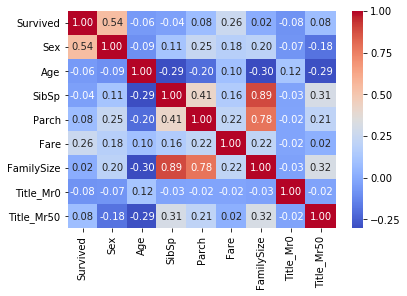

In [82]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train_copy.iloc[:,:10].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

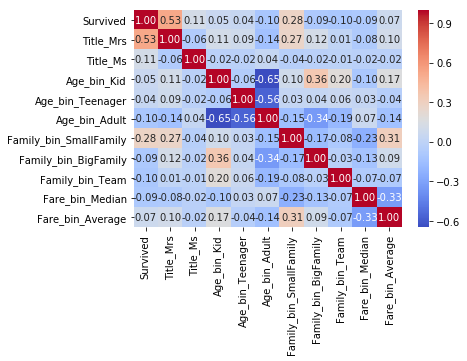

In [83]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
cor_range = [0]
cor_range.extend(list(range(10,20)))
sns.heatmap(train_copy.iloc[:,cor_range].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

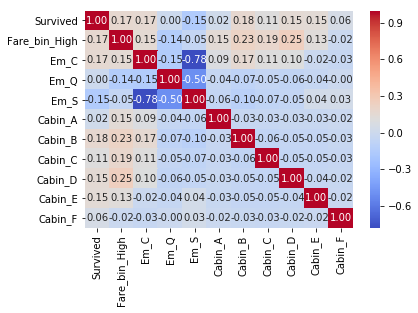

In [84]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
cor_range = [0]
cor_range.extend(list(range(20,30)))
sns.heatmap(train_copy.iloc[:,cor_range].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [85]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
cor_range = [0]
cor_range.extend(list(range(43,53)))
sns.heatmap(train_copy.iloc[:,cor_range].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

IndexError: positional indexers are out-of-bounds

In [ ]:
Outliers_to_drop2 = detect_outliers(train_copy,7,train_copy.columns)

In [ ]:
len(Outliers_to_drop2)

**We will need first to do some Feature Selection to reduce the outliers!**